# OutputActivityRatios
- Calculate any needed output activity ratios, including for petroleum refinement

In [ ]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede.core.support_classes as sc
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.utilities._toolbox as sf
import utils.common_data_needs as cdn
import warnings
warnings.filterwarnings("ignore")

from typing import *

plt.style.use("dark_background", )



In [3]:
dict_ssp = cdn._setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )

# setup region
_REGION_NAME = "uganda"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso")



# SET SOME GLOBALS

# fields
_FIELD_SSP_ENTC = matt.get_subsector_attribute("Energy Technology", "pycategory_primary_element")
_FIELD_PURCHASES_TOTAL = "total_purchases_kwh"
_FIELD_QUARTER = "Quarter"
_FIELD_SALES_TOTAL = "total_sales_kwh"
_FIELD_YEAR = "Year"

# flags
_FLAG_DROP = "_DROP"

# sheets in the table
_SHEET_PURCHASES = "Energy_Purchased_kWh"
_SHEET_SALES = "Energy Sales_kWh"

# units associated with input data
_UNITS_DATASET_ERA = "kwh"

# year to build estimates out to
_YEAR_TARGET = 2100

# Load data we'll work with

- The [2023 Uganda/IEA Energy Transition Plan](https://www.iea.org/reports/uganda-energy-transition-plan) describes a number of useful modeling assumptions that we seem to adopt
- The fractional share of fuels by refinement is helpful

![Refinery Output Fractions](./input_data/iea_etp/refinery_output_activity_ratio.png)

In [20]:
    
# get some SISEPUEDE elements
attr_entc = matt.get_attribute_table("Energy Technology")
modvar_tlf = matt.get_variable(
    models.model_enerprod.modvar_enfu_transmission_loss_frac_electricity,
)


# base dataset
df_uganda = cdn.get_raw_ssp_inputs()


# set variables and category to adjust
_DICT_MODVARS_TARGETS = {
    "Fuel Production NemoMod OutputActivityRatio Diesel": 0.22,
    "Fuel Production NemoMod OutputActivityRatio Gasoline": 0.46,
    "Fuel Production NemoMod OutputActivityRatio Hydrocarbon Gas Liquids": 0.07,
    "Fuel Production NemoMod OutputActivityRatio Kerosene": 0.04,
    "Fuel Production NemoMod OutputActivityRatio Oil": 0.04,   
}

_SSP_CAT_ENTC = "fp_petroleum_refinement"

# year to estimate out to
_YEAR_TARGET = 2100

In [36]:
modvar.schema.schema_raw

'``nemomod_entc_output_activity_ratio_fuel_production_$CAT-TECHNOLOGY$_oil``'

In [33]:
df_oar_refinement = pd.DataFrame(
    {
        time_periods.field_year: range(2015, _YEAR_TARGET + 1),
    }
)

fields_oar = []

for modvar, frac in _DICT_MODVARS_TARGETS.items():
    modvar = matt.get_variable(modvar, )
    field = modvar.build_fields(category_restrictions = _SSP_CAT_ENTC, )

    fields_oar.append(field)
    df_oar_refinement[field] = frac

([<matplotlib.patches.Wedge at 0x356c13d90>,
 [Text(0.7401597982753384, 0.8137342766634638, 'diesel (0.22%)'),
  Text(-1.0616152260211367, -0.28805053702447997, 'gasoline (0.46%)'),
  Text(0.7088366644911542, -0.8411602600414829, 'hydrocarbon_gas_liquids (0.07%)'),
  Text(0.9884705050343366, -0.48262414017241595, 'kerosene (0.04%)'),
  Text(1.0874166038341415, -0.16590699113003585, 'oil (0.04%)')])

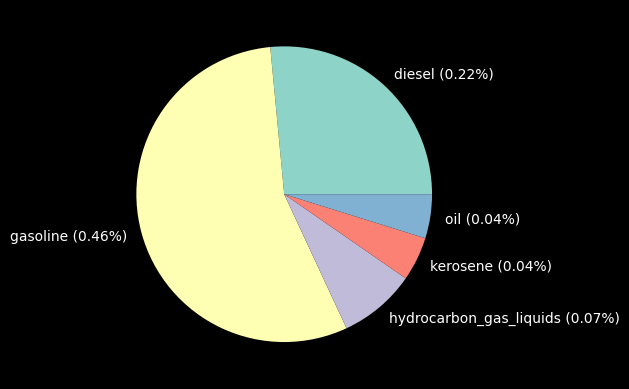

In [43]:
vec = df_oar_refinement[fields_oar].iloc[0].to_numpy()


plt.pie(
    vec,
    labels = [
        x.replace("nemomod_entc_output_activity_ratio_fuel_production_fp_petroleum_refinement_", "") + f" ({vec[i]}%)"
        for i, x in enumerate(fields_oar)
    ],
)

# Write Output

In [44]:

df_oar_refinement.to_csv(
    cdn._PATH_OUTPUTS.joinpath(f"OUTPUT_ACTIVITY_RATIOS_REFINEMENT.csv"),
    encoding = "UTF-8",
    index = None,
)